In [75]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance(row):
    coord1 = (row['LATITUDE:'], row['LONGITUDE:'])
    coord2 = (-15.765885, -47.871837)
    return geodesic(coord1, coord2).kilometers

df = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

df["Distancia"] = df.apply(calculate_distance, axis=1) 

df_lower_distance = df[df["Distancia"] < 50]

print(df_lower_distance)



    REGIAO: UF:            ESTACAO: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
62       CO  DF            BRASILIA          A001  -15.78944444  -47.92583332   
63       CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   
90       CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
358      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
429      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   

    ALTITUDE:                                            Arquivo  Distancia  
62    1160.96  INMET_CO_DF_A001_BRASILIA_01-01-2023_A_31-12-2...   6.346028  
63      990.0  INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2023_...  34.075013  
90     1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2023...  43.322909  
358   1030.36  INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2023_A_...  32.357785  
429    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2023_A_31-12...  33.325880  


<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 0 to 43799
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Data                                                   43800 non-null  datetime64[ns]
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       42073 non-null  float64       
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  42612 non-null  float64       
 3   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        42598 non-null  float64       
 4   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       42598 non-null  float64       
 5   RADIACAO GLOBAL (Kj/m²)                                23394 non-null  float64       
 6   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           42628 non-null  float64       
 7   TEMPERATURA DO PONTO DE ORVALHO (°C)                   42625 non-null  f

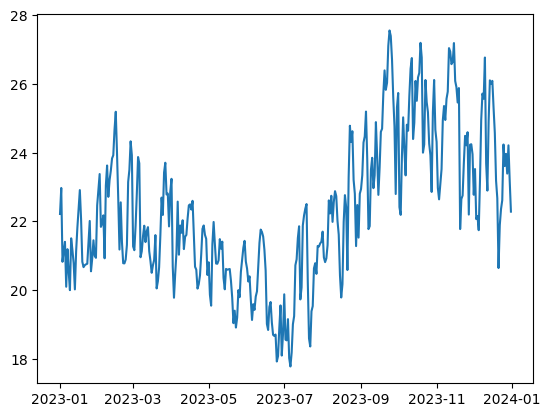

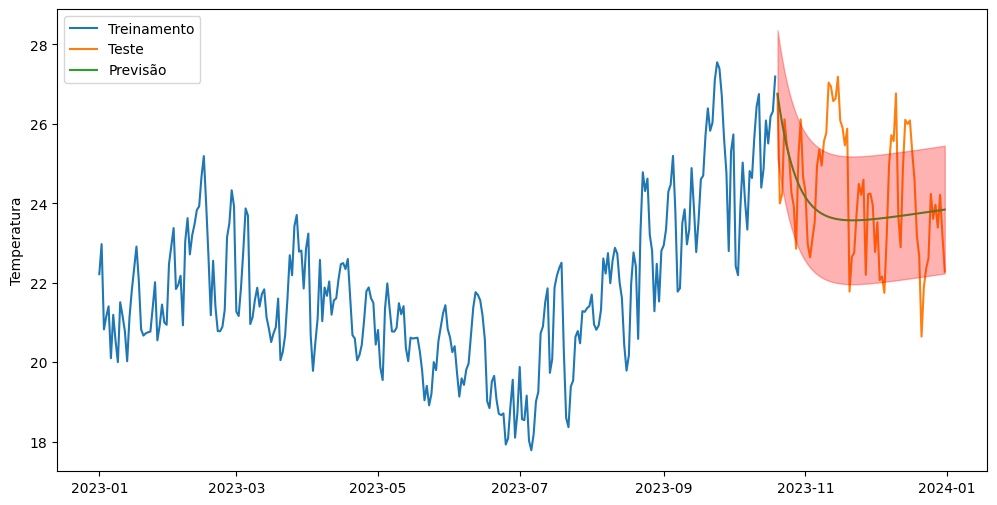

In [76]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

ListDataframe = []

for filename in df_lower_distance['Arquivo']: 
    df = pd.read_csv(f'../data/2023_cleaned/{filename}', decimal=".", sep=";")
    ListDataframe.append(df)

df_near_stations = pd.concat(ListDataframe, ignore_index= True)


#mudando tipo para string
df_notimecollumn = df_near_stations.drop(columns=['Hora UTC'])

df_notimecollumn['Data'] = pd.to_datetime(df_notimecollumn['Data'])

df_ordenado = df_notimecollumn.sort_values(by='Data', ascending=True)

df_ordenado.info()

column_name = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# print(df_notimecollumn.info())
# print(df_notimecollumn.info())
#print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

print(df_notimecollumn.info())

#Converte Data
#df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
df_ordenado.set_index('Data', inplace=True)
df_ordenado = df_ordenado.resample("D").mean()

print(df_ordenado)

#Teste
plt.plot(df_ordenado[column_name], label='Previsão')
plt.savefig('data.png')

# Verificar se há valores nulos
print(df_ordenado.isnull().sum())

# Tratar valores nulos
df_ordenado = df_ordenado.ffill()

# Divisão dos dados em treinamento (80%) e teste (20%)
train_size = int(len(df_ordenado) * 0.8)
train, test = df_ordenado[:train_size], df_ordenado[train_size:]

# Ajuste do modelo ARIMA
model = ARIMA(train[column_name], order=(1, 0, 0), trend='ct')
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test))

# Visualização das previsões
plt.figure(figsize=(12,6))
plt.plot(train.index, train[column_name], label='Treinamento')
plt.plot(test.index, test[column_name], label='Teste')
plt.plot(test.index, forecast, label='Previsão')
plt.ylabel('Temperatura')
plt.legend(loc='upper left')

# Cálculo erro quadrático
mse = mean_squared_error(test[column_name], forecast)
rmse = mse**0.5 
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
plt.fill_between(test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

# Salva o gráfico como arquivo de imagem
plt.savefig('forecast.png')





    


In [77]:
df_ordenado

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
Data,,,,,,,,,,,,,,,,,
2023-01-01,0.043103,895.443966,895.736207,895.216379,1603.504286,22.217241,17.562069,22.837069,21.523276,18.170690,17.007759,80.387931,74.198276,76.982759,108.767241,4.936207,1.987069
2023-01-02,0.383193,894.386555,894.736975,894.088235,1738.766197,22.973950,17.147899,23.688235,22.321008,17.763866,16.536975,75.033613,67.470588,71.386555,120.126050,5.435294,2.210924
2023-01-03,0.532773,894.181513,894.468908,893.863025,1142.455714,20.827731,17.630252,21.439496,20.278992,18.111765,17.137815,85.672269,79.663866,83.000000,207.857143,4.082353,1.549580
2023-01-04,0.015652,894.420870,894.710435,894.151304,1363.725714,21.154783,17.806957,21.798261,20.580870,18.321739,17.338261,85.113043,79.252174,82.295652,245.486957,5.132174,2.068696
2023-01-05,0.116949,894.243220,894.511864,893.986441,1271.071014,21.407627,17.916949,21.927119,20.826271,18.327966,17.500847,84.042373,78.711864,81.313559,272.737288,4.875424,1.916102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.029091,895.848182,896.123636,895.647273,1698.978571,23.965455,17.841818,24.778182,23.116364,18.712727,16.997273,75.772727,66.709091,71.118182,195.781818,4.479091,1.710000
2023-12-28,0.057895,895.275439,895.525439,895.026316,1317.754286,23.392105,18.395614,24.348246,22.487719,19.099123,17.664912,79.377193,70.008772,74.894737,147.508772,4.453509,1.642105
2023-12-29,0.000000,894.816364,895.100909,894.587273,1336.317143,24.212727,18.722727,25.071818,23.359091,19.356364,18.002727,77.272727,68.918182,73.327273,193.072727,4.437273,1.581818
